In [1]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from scipy import interpolate
import seaborn as sns

from MapXtremePCIC import MapXtremePCIC

In [2]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC('110m', 'eof', PATH, 'pr')
data_cube = MapXtreme.read_data()

(27, 177)


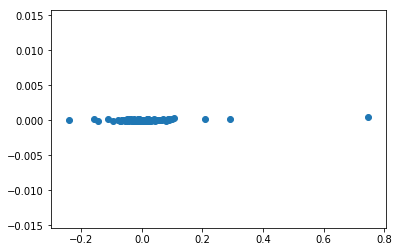

[ 6.96113690e-05 -4.34091242e-05  5.42110549e-05 ... -6.37798224e-05
 -1.22828701e-04 -4.55159270e-05]
(8843, 39)


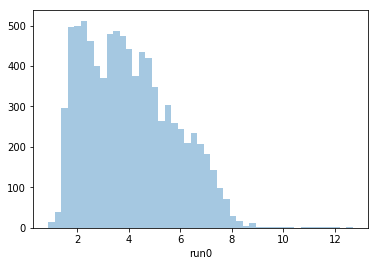

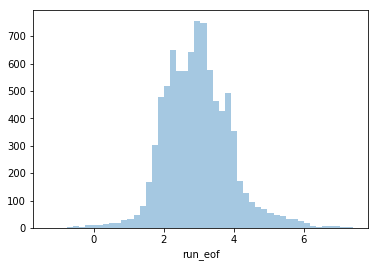

In [20]:
df_assemble = MapXtreme.ensemble_mean()
df_weight = MapXtreme.standard_matrix(df_assemble).dropna()

df_pseudo_weighted = df_weight.sample(frac = 0.02, random_state = 7)

no, po, Xo = MapXtreme.get_arr(df_weight)
n, p, X = MapXtreme.get_arr(df_pseudo_weighted)

skpca = pca.PCA()
skpca.fit(X)

skpcao = pca.PCA()
skpcao.fit(Xo)

ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.95)[0][0]
EOFs = skpca.components_
EOFs = EOFs[:ipc, :]

ipco = np.where(skpcao.explained_variance_ratio_.cumsum() >= 0.95)[0][0]
EOFos = skpcao.components_
EOFos = EOFos[:ipc, :]

print(EOFs.shape)
# reconstruct the field map
x = EOFs[0, :]

# psuedo observations
y = df_pseudo_weighted['run0'].values

plt.scatter(x, y)
plt.show()

f = interpolate.interp1d(x, y)

# reconstruct observed field from this interpolation
X_new = f(EOFos[0, :])

print(X_new)

df_weight['run_eof'] = X_new

print(df_weight.dropna().shape)
#df_weight = df_weight.dropna()
df_reasembled = MapXtreme.standard_matrix(df_weight, reverse = True, mean_run = 0)

#sns.distplot(df_reasembled['run_eof'])
sns.distplot(df_reasembled['run0'], kde=False) # no NaN
plt.show()
sns.distplot(df_reasembled['run_eof'], kde=False) # has NaN --> difference is concerning
plt.show()

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

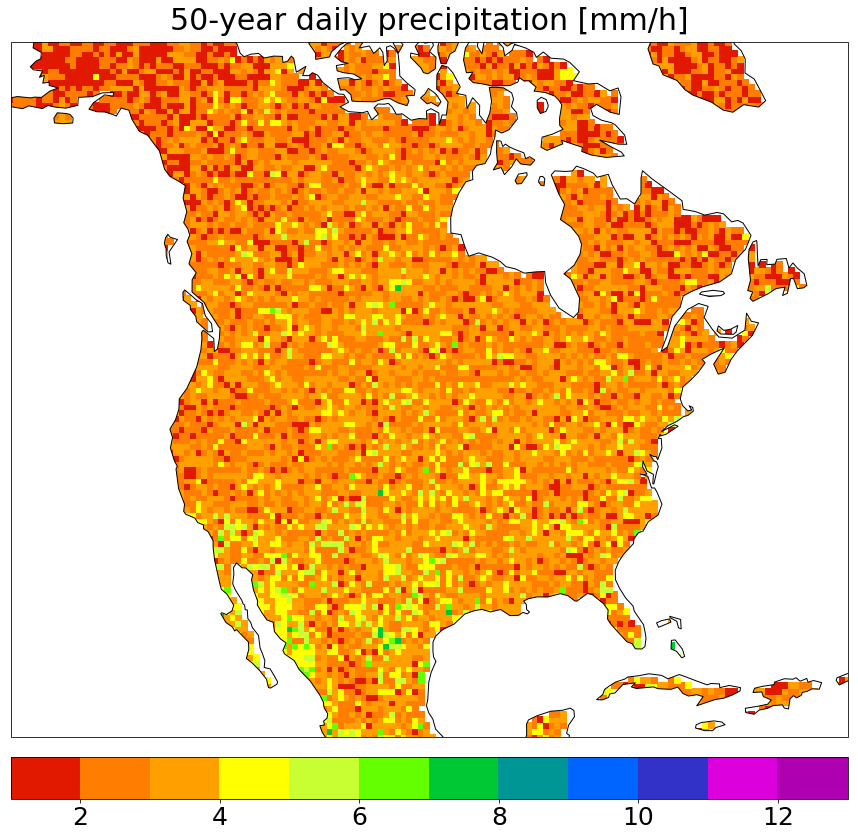

In [21]:
rp = MapXtreme.rp()
ocean = MapXtreme.ocean_mask()
cmap = MapXtreme.color_pallette()

plt.figure(figsize = (15, 15))

rlon = df_reasembled['rlon']
rlat = df_reasembled['rlat']
N = df_reasembled['run_eof']

# define projections
ax = plt.axes(projection=rp)#ccrs.PlateCarree())
ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
colorplot = ax.scatter(rlon, rlat, c = N, marker='s', cmap=cmap, vmin=1., vmax=13.)
cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)
cbar.ax.tick_params(labelsize=25)

# constrain to data
plt.xlim(rlon.min(), rlon.max())
plt.ylim(rlat.min(), rlat.max())

# return/undo the supress invalid warning
np.seterr(invalid = 'warn')

In [87]:
#df = MapXtreme.standard_matrix(reverse = True)
#sns.distplot(df['run1'].dropna())


dfo_o = MapXtreme.sample(frac = 1, seed = 7, dropna = False)
dfo = dfo_o.copy().dropna()
y_g = dfo.sample(frac = 0.02)

dfo = dfo_o.copy().dropna()
y_g = dfo.sample(frac = 0.02)

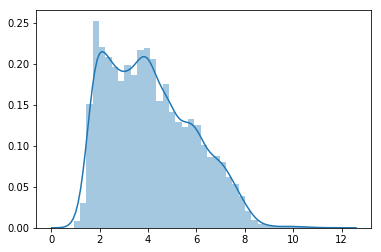

In [88]:
sns.distplot(dfo['run1'].values)#, 'run2','run3','run4','run5','run6','run7','run8','run9','run10']])

In [89]:
y_g['obs_y'] = y_g['run1'].values
df = pd.concat([y_g['obs_y'], dfo], axis=1).dropna()

y_g_arr = np.subtract(df['obs_y'], df['obs_y'].mean())

In [90]:
df['frac_area'] = df['areas']/df['areas'].sum()
dfo['frac_area'] = dfo['areas']/dfo['areas'].sum()

mean = df['obs_y'].mean()

X_arr = MapXtremePCIC.get_arr(MapXtreme, df)[2]
Xo_arr = MapXtremePCIC.get_arr(MapXtreme, dfo)[2]

Xp = np.subtract(X_arr, X_arr.mean(axis=0))
Xpo = np.subtract(Xo_arr, Xo_arr.mean(axis=0))

W = np.diag(df['frac_area'].values)
Wo = np.diag(dfo['frac_area'].values)

X = np.matmul(Xp, W)
Xo = np.matmul(Xpo, Wo)

y_w = np.matmul(y_g_arr, W)

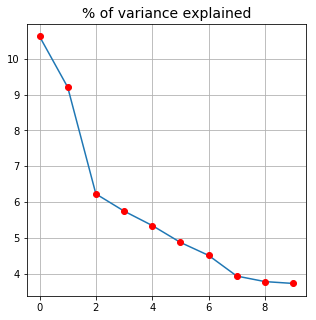

(35, 177) (27, 177)
(177,)
(8843,) (35, 8843)


Text(0.5, 1.0, '')

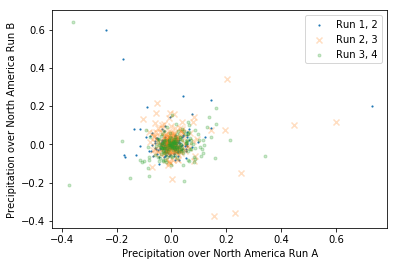

In [105]:
skpca = pca.PCA()
skpca.fit(X)

skpcao = pca.PCA()

f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()
plt.show()

ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.95)[0][0]

EOFs = skpca.components_

EOFs = EOFs[:ipc, :]

print(X.shape, EOFs.shape)

# reconstruct the field map
x = EOFs[0, :]
y = y_w
print(x.shape)
f = interpolate.interp1d(x, y)

# reconstruct observed field from this interpolation
#X_new = f(Xo[0, :])
print(X_new.shape, Xo.shape)


plt.scatter(EOFs[0,:], EOFs[1, :], s = 1.3, label = 'Run 1, 2')
plt.scatter(EOFs[1,:], EOFs[2, :], marker = 'x', alpha = 0.25, label = 'Run 2, 3')
plt.scatter(EOFs[2,:], EOFs[3, :], marker = '.', alpha = 0.25, label = 'Run 3, 4')
plt.legend()
plt.xlabel('Precipitation over North America Run A')
plt.ylabel('Precipitation over North America Run B')
plt.title('')

#plt.hist(np.hstack(y_g_arr))
#plt.hist(np.hstack(X_new))
#sns.distplot(np.hstack(X_new))
#sns.distplot(np.hstack(y))

In [92]:
dfo['eof'] = np.dot(X_new, Wo[0, :].T) + Xo_arr.mean(axis=0)

In [93]:
dfo['eof']

17582    1.844270
9251     5.243452
1318     3.184986
17337    2.290239
6844     1.543232
15026    2.297347
7512     6.869534
16199    2.363321
3324     7.583213
5719     5.973979
6694     5.447191
12840    3.129396
2573     3.452663
10746    3.902085
11461    4.118913
15583    3.607255
13569    2.543940
5852     6.870714
12688    3.162943
14701    3.346674
6155     5.970278
14398    3.874767
13729    2.738843
16757    2.228401
8532     4.642508
7349     5.226503
5884     7.389891
6028     7.399180
11610    3.996161
15794    2.291142
           ...   
14539    2.184597
12690    3.177914
13395    2.981762
13442    3.207673
1439     4.967823
5085     3.368827
8225     5.573992
9877     4.716160
1248     3.862546
16476    2.339432
5437     7.202192
10985    3.942926
6423     5.688583
6748     5.831865
11180    4.313164
16641    2.080202
8964     5.340502
14537    1.816505
8504     5.090861
12471    2.965029
3896     3.270833
7955     6.764446
13387    3.332117
17840    1.467349
1092     9

In [94]:
#N = np.dot(dfo['eof'].values, np.linalg.inv(Wo))

In [95]:
#N_n = (N + df['obs_y'].mean())

In [24]:
rp = MapXtremePCIC.rp()
ocean = MapXtremePCIC.ocean_mask('110m')
cmap = MapXtremePCIC.color_pallette()

plt.figure(figsize = (15, 15))

rlon = dfo['rlon']
rlat = dfo['rlat']
N = dfo['eof']

# define projections
ax = plt.axes(projection=rp)#ccrs.PlateCarree())
ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
colorplot = ax.scatter(rlon, rlat, c = N, marker='s', cmap=cmap, vmin=1., vmax=13.)
cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)
cbar.ax.tick_params(labelsize=25)

# constrain to data
plt.xlim(rlon.min(), rlon.max())
plt.ylim(rlat.min(), rlat.max())

# return/undo the supress invalid warning
np.seterr(invalid = 'warn')

AttributeError: 'str' object has no attribute 'res'

In [25]:
#dfo_fine = dfo[['rlat', 'rlon', 'eof']].sort_values(by=['rlat', 'rlon']).copy()

In [14]:
from scipy.signal import resample
import scipy.misc

dfo_resampled = pd.DataFrame()


dlon = np.diff(dfo['rlon'].sort_values()).mean()
dlat = np.diff(dfo['rlat'].sort_values()).mean()

df_to_reshape = pd.concat([dfo_o, dfo], axis=1)
df_to_reshape['eof'].shape
#dfo_resampled['rlat'] = np.tile(dfo_fine['rlat'].values, 100)
#dfo_resampled['rlon'] = np.repeat(dfo_fine['rlon'].values, 100)

#N = dfo_fine['rlat'].shape[0]*100

#rlat_resampled = resample(dfo_fine['rlat'].values, N)
#rlon_resampled = resample(dfo_fine['rlon'].values, N)

(18204,)

In [15]:
xx = data_cube['rlat'].shape[0]-1
yy = data_cube['rlon'].shape[0]-1

xlon = data_cube['rlon'][:-1].values
ylat = data_cube['rlat'][:-1].values
#dfo_resampled_new = pd.concat([dfo_fine, dfo_resampled])
#y_eof = dfo_resampled_new['eof'].dropna()

In [16]:
#dfo_resampled['rlat'] = np.tile(dfo_fine['rlat'].values, 100)
#dfo_resampled['rlon'] = np.tile(dfo_fine['rlon'].values, 100)

In [17]:
eof_arr = np.reshape(df_to_reshape['eof'].values, (xx, yy))

In [18]:
#f2d_interp = interpolate.griddata((xlon, ylat), eof_arr, method='linear')

In [19]:
N = 20
n = np.linspace(-N/2, N/2, N+1)
xlon_up = np.ones((xlon.shape[0], N+1))
ylat_up = np.ones((ylat.shape[0], N+1))

xlon_diff = np.diff(np.sort(xlon)).mean()
ylat_diff = np.diff(np.sort(ylat)).mean()

dx = n*(xlon_diff/N)
dy = n*(ylat_diff/N)

print(xlon_up.shape)

for i in range(xlon_up.shape[0]):
    xlon_up[i, :] = xlon[i] + xlon[i]*dx
    
for i in range(ylat_up.shape[0]):
    ylat_up[i, :] = ylat[i] + ylat[i]*dy

rlon_up = np.reshape(xlon_up, (xlon_up.shape[0]*xlon_up.shape[1])) 
rlat_up = np.reshape(ylat_up, (ylat_up.shape[0]*ylat_up.shape[1]))

rlat_upp = np.tile(rlon_up, rlat_up.shape[0])
rlon_upp = np.repeat(rlat_up, rlon_up.shape[0])

rlat = np.tile(xlon, ylat.shape[0])
rlon = np.repeat(ylat, xlon.shape[0])
    
print(rlon_up, rlat_up)

z = eof_arr

grid_x, grid_y = np.meshgrid(rlon_up, rlat_up)
points = np.asarray(list(zip(rlon, rlat)))

print(points.shape)

f2d_interp = interpolate.griddata(points, z, (grid_x, grid_y), method='linear')
#eof_interp = f2d_interp(rlon_up, rlat_up)
#eof_interp

(148, 21)
[-25.39680912 -26.11312949 -26.82944986 ...  37.77311495  38.47975493
  39.18639491] [-21.27839901 -21.87855899 -22.47871897 ...  31.04640182  31.62720186
  32.20800189]
(18204, 2)


ValueError: different number of values and points

/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/numpy/ma/core.py:718: UserW

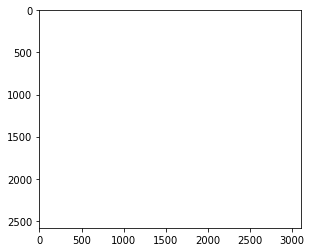

In [35]:
plt.imshow(eof_interp)

/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/numpy/ma/core.py:718: UserW

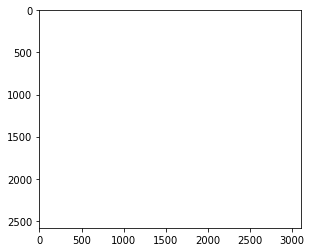

In [23]:
np.seterr(invalid = 'ignore')

data_cube = MapXtreme.load_data
res = MapXtreme.res

# take mean of all simulation runs
N = eof_interp

# custom colormap
cmap = MapXtremePCIC.color_pallette()

# ocean mask
ocean = MapXtremePCIC.ocean_mask(res)

# custom ax object with projection
rp = MapXtremePCIC.rp()

#plt.figure(figsize = (15, 15))

# define projections
#ax = plt.axes(projection = rp)
#ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
#ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
#colorplot = plt.pcolormesh(rlon_up, rlat_up, N, transform=rp, cmap=cmap, vmin=1., vmax=13.)
plt.imshow(N)
cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)
cbar.ax.tick_params(labelsize=25)

In [ ]:
#plt.imshow(res, transform=rp)

12300


MemoryError: 

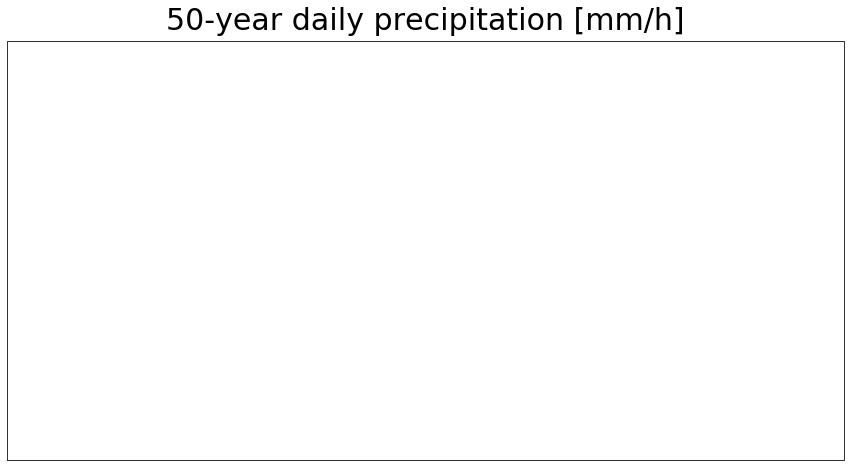

In [28]:
rp = MapXtremePCIC.rp()
ocean = MapXtremePCIC.ocean_mask('110m')
cmap = MapXtremePCIC.color_pallette()

plt.figure(figsize = (15, 15))

rlon = dfo['rlon']
rlat = dfo['rlat']
N = dfo['eof']

# define projections
ax = plt.axes(projection=rp)#ccrs.PlateCarree())
ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
#ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
#colorplot = ax.scatter(rlon, rlat, c = N, marker='s', cmap=cmap, vmin=1., vmax=13.)
#cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)

ax.imshow(res, transform=rp)
ax.invert_yaxis()

cbar.ax.tick_params(labelsize=25)

# constrain to data
plt.xlim(rlon.min(), rlon.max())
plt.ylim(rlat.min(), rlat.max())

# return/undo the supress invalid warning
np.seterr(invalid = 'warn')